# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

data_dir = '/data/landmark_images'

train_transforms = transforms.Compose([transforms.RandomResizedCrop(256),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                            std=[0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                            std=[0.5, 0.5, 0.5])])

batch_size = 32
valid_size = 0.2

train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=test_transforms)


num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=train_sampler)

valid_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


loaders_scratch = {'train': train_dataloader, 'valid': valid_dataloader, 'test': test_dataloader}


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
- I resized the images by using PyTorch transforms transforms.Resize(),transforms.CenterCrop() with 256 pixels as the parameter as I thought making it some power of two would harness the parallizing capability of the GPU as well as making all the hidden mapping also powers of two.
- Yes. To provode the train data some randomness so the model can generalize better through PyTourch transforms.RandomResizedCrop(256), transforms.RandomHorizontalFlip().

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

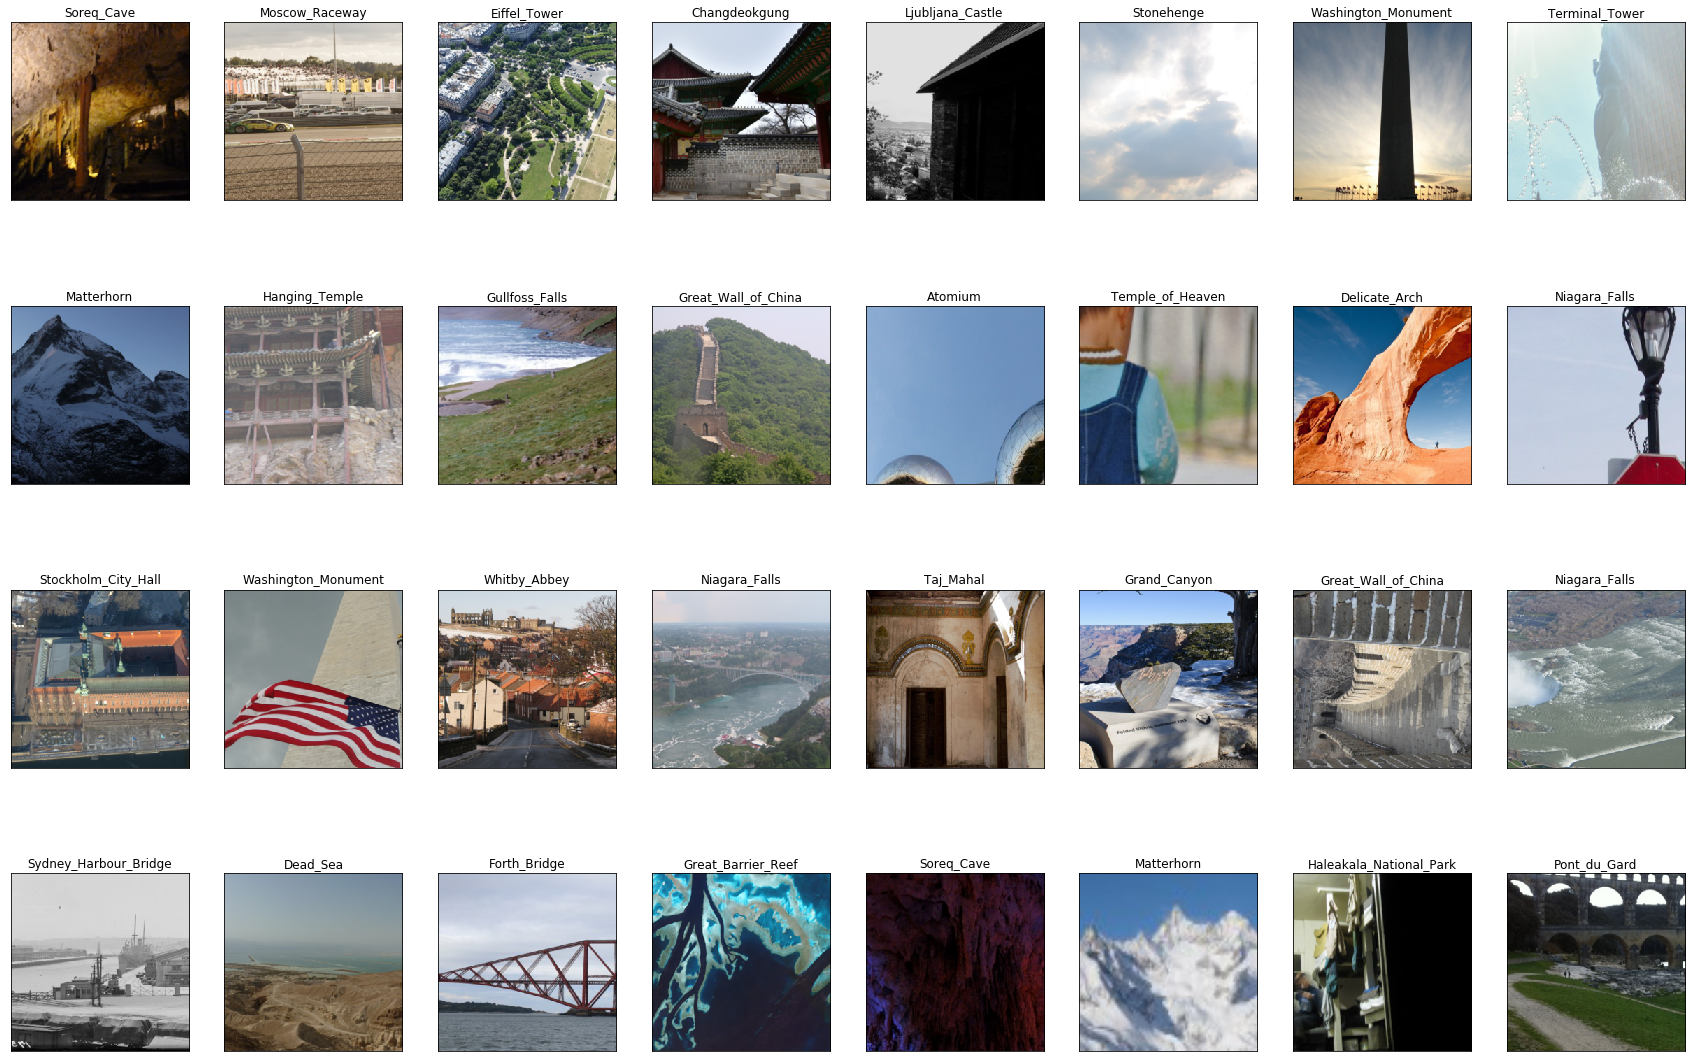

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

dataiter = iter(train_dataloader)
images, labels = dataiter.next()
images = images.numpy()


fig = plt.figure(figsize=(30, 20))
for idx in np.arange(len(labels)):
    ax = fig.add_subplot(4, int(32 / 4), idx+1, xticks=[], yticks=[])
    ax.imshow((images[idx].transpose(1, 2, 0) * 0.5) + 0.5)
    ax.set_title(train_dataset.classes[labels[idx].item()][3:])   

### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
use_cuda

True

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
## TODO: select loss function
from torch import nn, optim
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.Adam(model.parameters(), lr=0.003)
    
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc2_bn = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 50)

        self.dropout = nn.Dropout(0.25)
        
        
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))
        x = self.pool(F.relu(self.conv5_bn(self.conv5(x))))
        # flatten image input
        x = x.view(-1, 256 * 8 * 8)
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x) 
        return x


#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  In the feature extraction layer, I begin with three conv2d layers but the model wasn't conplex enough so I tried give it 5 conv2d layers each one captures more comples fretures. I used the ReLU activation as it's suited for the problem and used batch normalzation to snandarize the inputs for each layer and make the learning process takes less epochs. Then I flattened the mapping of the last leyer to equip it for the classifier layer. In the classifier layer I made the outputs of the first two 1024, 512 so they are powers of two, and the last one 50 as that is the number of classes. I used the ReLU and dropout with probability 0.25 to make the model lighter and avoid overfitting. I could use a softmax layers here but I decided to make it that way to make it compatible with the criterion and apply a softmax in the training/testing loop.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            #train_loss += loss.item()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            #valid_loss += loss.item()
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if(valid_loss <= valid_loss_min):
            print('Valid loss decresed ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
        
    
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(5, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.807635 	Validation Loss: 3.720881
Valid loss decresed (inf --> 3.720881). Saving model ...
Epoch: 2 	Training Loss: 3.569140 	Validation Loss: 3.583733
Valid loss decresed (3.720881 --> 3.583733). Saving model ...
Epoch: 3 	Training Loss: 3.345067 	Validation Loss: 3.295057
Valid loss decresed (3.583733 --> 3.295057). Saving model ...
Epoch: 4 	Training Loss: 3.200419 	Validation Loss: 3.391648
Epoch: 5 	Training Loss: 3.101372 	Validation Loss: 3.214738
Valid loss decresed (3.295057 --> 3.214738). Saving model ...


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 40

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.780876 	Validation Loss: 3.747813
Valid loss decresed (inf --> 3.747813). Saving model ...
Epoch: 2 	Training Loss: 3.482455 	Validation Loss: 3.405895
Valid loss decresed (3.747813 --> 3.405895). Saving model ...
Epoch: 3 	Training Loss: 3.310270 	Validation Loss: 3.548643
Epoch: 4 	Training Loss: 3.191993 	Validation Loss: 3.362275
Valid loss decresed (3.405895 --> 3.362275). Saving model ...
Epoch: 5 	Training Loss: 3.072882 	Validation Loss: 3.089373
Valid loss decresed (3.362275 --> 3.089373). Saving model ...
Epoch: 6 	Training Loss: 2.982927 	Validation Loss: 3.229505
Epoch: 7 	Training Loss: 2.906090 	Validation Loss: 3.110254
Epoch: 8 	Training Loss: 2.820747 	Validation Loss: 3.005601
Valid loss decresed (3.089373 --> 3.005601). Saving model ...
Epoch: 9 	Training Loss: 2.753156 	Validation Loss: 2.887044
Valid loss decresed (3.005601 --> 2.887044). Saving model ...
Epoch: 10 	Training Loss: 2.714835 	Validation Loss: 2.950336
Epoch: 11 	Training Lo

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [7]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [7]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.696117


Test Accuracy: 58% (733/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [8]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

import numpy as np
import torch
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

data_dir = '/data/landmark_images'

train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                            std=[0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                            std=[0.5, 0.5, 0.5])])

batch_size = 32
valid_size = 0.2

train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=test_transforms)


num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=train_sampler)

valid_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

loaders_transfer = {'train': train_dataloader, 'valid': valid_dataloader, 'test': test_dataloader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [9]:
## TODO: select loss function
from torch import nn, optim
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.Adam(model.classifier.parameters(), lr=0.001)    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [10]:
## TODO: Specify model architecture
model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features
added_last_layer = nn.Linear(n_inputs, len(train_dataset.classes))
model_transfer.classifier[6] = added_last_layer

print(model_transfer)
#-#-# Do NOT modify the code below this line. #-#-#
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:09<00:00, 59217594.17it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I searched the problem and I fould a project that used vgg16 on the kaggle challenge for this dataset. I also tried vgg19 but the learning was too slow. I looked at the number of input for the last layer first and replace it with another one suited fot this problem that has the same numper of inputs ans 50 outputs as we have only 50 classes and turned off the gradients for the feature layer and only training the classifier layer

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [16]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
model_scratch = train(30, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.900121 	Validation Loss: 2.103883
Valid loss decresed (inf --> 2.103883). Saving model ...
Epoch: 2 	Training Loss: 2.369498 	Validation Loss: 2.012827
Valid loss decresed (2.103883 --> 2.012827). Saving model ...
Epoch: 3 	Training Loss: 2.381739 	Validation Loss: 1.910287
Valid loss decresed (2.012827 --> 1.910287). Saving model ...
Epoch: 4 	Training Loss: 2.301867 	Validation Loss: 1.938393
Epoch: 5 	Training Loss: 2.170301 	Validation Loss: 1.904261
Valid loss decresed (1.910287 --> 1.904261). Saving model ...
Epoch: 6 	Training Loss: 2.186442 	Validation Loss: 1.797327
Valid loss decresed (1.904261 --> 1.797327). Saving model ...
Epoch: 7 	Training Loss: 2.252601 	Validation Loss: 1.901577
Epoch: 8 	Training Loss: 2.160473 	Validation Loss: 1.767471
Valid loss decresed (1.797327 --> 1.767471). Saving model ...
Epoch: 9 	Training Loss: 2.071368 	Validation Loss: 1.945044
Epoch: 10 	Training Loss: 2.047106 	Validation Loss: 1.727546
Valid loss decresed (1

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [17]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.263104


Test Accuracy: 71% (889/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [14]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                            std=[0.5, 0.5, 0.5])])
    image = Image.open(img_path)
    image = test_transforms(image).unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    output = model_transfer(image)
    _, predictied_class_index = torch.topk(output, k)
    top_k_classes_names = [train_dataset.classes[p.item()][3:] for p in predictied_class_index.squeeze()]
    return top_k_classes_names

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden_Gate_Bridge',
 'Dead_Sea',
 'Haleakala_National_Park',
 'Forth_Bridge',
 'Banff_National_Park']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this pictures of the
Golden_Gate_Bridge, Forth_Bridge, or Brooklyn_Bridge?


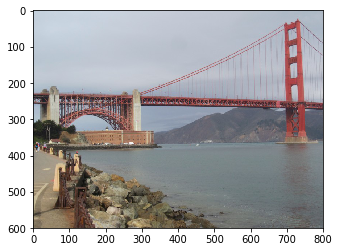

In [16]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img) 
    
    print('Is this pictures of the')
    print(f'{predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?')
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
It's not good but it's expected.
- For the first two tests, the images are clear and hence the model doesn't recognize them so it's clear that it need more data for training.
- For the third test, the model should recognize that this's a river so maybe it need more trainig and a more complex model with more data.
- For the last test, the model did well as the image is clear and it trained on many similar data for this class, but if the tower was inclined then more data augmentation techniques would help.

Is this pictures of the
Delicate_Arch, Death_Valley_National_Park, or Dead_Sea?


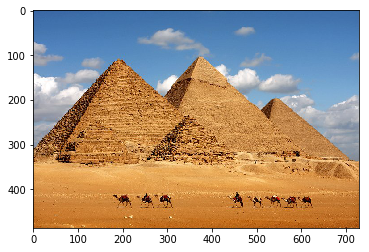

In [20]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

img1_path = 'Test_Images/Pyramids.jpg' 
suggest_locations(img1_path)

Is this pictures of the
Taj_Mahal, Temple_of_Olympian_Zeus, or Pont_du_Gard?


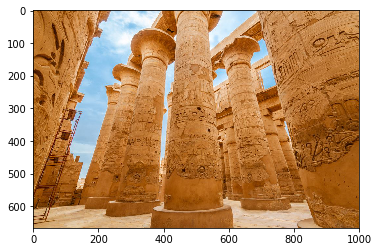

In [21]:
img2_path = 'Test_Images/Karnak.jpg' 
suggest_locations(img2_path)

Is this pictures of the
Sydney_Harbour_Bridge, Sydney_Opera_House, or Terminal_Tower?


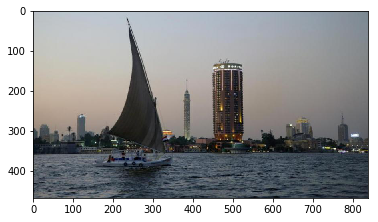

In [22]:
img3_path = 'Test_Images/River_Nile.jpg' 
suggest_locations(img3_path)

Is this pictures of the
Eiffel_Tower, Forth_Bridge, or Monumento_a_la_Revolucion?


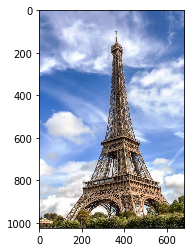

In [23]:
img4_path = 'Test_Images/Eiffel_Tower.jpg' 
suggest_locations(img4_path)